**Build a model to predict the value of the question in the TV game show  “Jeopardy!”.**


In [1]:

import numpy as np 
import pandas as pd 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)



**Importing necessary libraries**

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')

from stop_words import get_stop_words
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Reading Csv**

In [3]:
jeo_df = pd.read_csv(file_path)
print(f"Shape of jeo_df is :- {jeo_df.shape}")
jeo_df.head()

Shape of jeo_df is :- (216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [4]:
# Name of the columns
print(f"Column names:- {jeo_df.columns}")

Column names:- Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')


In [5]:
jeo_df.isna().count()

Show Number    216930
 Air Date      216930
 Round         216930
 Category      216930
 Value         216930
 Question      216930
 Answer        216930
dtype: int64

In [6]:
#Renaming the columns names since it contains spaces for few col names
jeo_df.columns = ["Show_Number", "Air_Date", "Round", "Category", "Value", "Question", "Answer"] 

Jeopardy!           0.495017
Double Jeopardy!    0.488231
Final Jeopardy!     0.016738
Tiebreaker          0.000014
Name: Round, dtype: float64



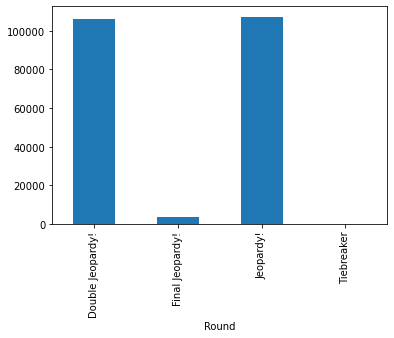

In [7]:
%matplotlib inline
# Function to draw bar plot
def get_catogorical_features_plot(feat_name, plot=True):
    if plot:
        jeo_df.groupby(feat_name).size().plot(kind = 'bar')
        rows = jeo_df.shape[0]
        res = jeo_df[feat_name].value_counts()/rows 
        print(res)
        print()
    else:
        res = jeo_df[feat_name].value_counts().shape[0]
        print(res)
        print()
    
  
get_catogorical_features_plot("Round") 

In [8]:
# When Round=="Final Jeopardy! or Round=="Tiebreaker" replace that with None
# and removing from the csv since there were very few number of rows containing this data 0.016% and  0.000014%
jeo_df['Value'] = np.where((jeo_df['Round'] == "Final Jeopardy!")
                           | (jeo_df['Round'] == "Tiebreaker"), 
                           "None",      
                           jeo_df['Value'])      
jeo_df = jeo_df[jeo_df['Value'] != "None"]
print(f"Shape of jeo_df is :- {jeo_df.shape}")


Shape of jeo_df is :- (213296, 7)


In [9]:
# Total unique show number
get_catogorical_features_plot("Show_Number", plot=False) 

3640



In [10]:
# Total Unique Category
get_catogorical_features_plot("Category", plot=False) 

26951



In [11]:
# Total Unique value
get_catogorical_features_plot("Value", plot=False) 

149



In [12]:
# Checking if any column contains null value or not
jeo_df.isnull().sum()

Show_Number    0
Air_Date       0
Round          0
Category       0
Value          0
Question       0
Answer         2
dtype: int64

In [13]:
jeo_df['Answer'].value_counts().to_frame()

,Answer
China,212
Australia,211
Japan,193
France,191
Chicago,189
...,...
University of Miami,1
hyperinflation,1
Never Give a Sucker an Even Break,1
TV judges,1


In [14]:
# Let's fill the answer with maximun number of repeating answer. Since only 2 of them is missing
jeo_df['Answer'] = jeo_df['Answer'].fillna(jeo_df['Answer'].mode()[0])

In [15]:
jeo_df["Question"].to_list()[:3]

["For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",
 'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves',
 'The city of Yuma in this state has a record average of 4,055 hours of sunshine each year']

In [16]:
jeo_df["Answer"].to_list()[:20]

['Copernicus',
 'Jim Thorpe',
 'Arizona',
 "McDonald's",
 'John Adams',
 'the ant',
 'the Appian Way',
 'Michael Jordan',
 'Washington',
 'Crate & Barrel',
 'Jackie Gleason',
 'the cud',
 'Ceylon (or Sri Lanka)',
 'Jim Brown',
 'the UV index',
 'Bulova',
 'Jesse James',
 'imp',
 'the International',
 '(Lou) Gehrig']

> As seen from above question answer, we can conclude that Answer to each question is a Noun

In [17]:
np.where((jeo_df['Round'] == "Jeopardy!")
                           & (jeo_df['Show_Number'] == 4680))[0].shape

(29,)

In [18]:
# Modifying Value column as numeric and reducing the number of classes to predict
jeo_df['Modified_Value'] = jeo_df['Value'].apply(
    lambda value: int(value.replace(',', '').replace('$', '').replace(" ", ""))
)
def binning(value):
    if value < 1000:
        return np.round(value, -2)
    elif value < 10000:
        return np.round(value, -3)
    else:
        return np.round(value, -4)

jeo_df['Modified_Bins'] = jeo_df['Modified_Value'].apply(binning)

In [19]:
jeo_df.head(5)

,Show_Number,Air_Date,Round,Category,Value,Question,Answer,Modified_Value,Modified_Bins
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,200,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,200,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,200,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,200,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,200,200


In [20]:
jeo_df['Modified_Bins'].value_counts().to_frame()

,Modified_Bins
400,42247
1000,33789
800,31865
200,30460
2000,25232
600,20379
100,9029
500,9016
300,8663
3000,1077


**Dropping 20000 bins since it has total count less than 3**

In [21]:
jeo_df = jeo_df[jeo_df['Modified_Bins'] != 20000] 

In [22]:
target = jeo_df["Modified_Bins"] 
jeo_df.drop(['Modified_Value', "Value", "Modified_Bins"], axis=1, inplace=True)


In [23]:
# stop_words = list(get_stop_words('en'))         
# nltk_words = list(stopwords.words('english'))
# stop_words.extend(nltk_words)
# stop_words = set(stop_words)
# len(stop_words)

In [24]:
#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
jeo_df["Date"] = pd.to_datetime(jeo_df['Air_Date'])
jeo_df.drop('Air_Date', axis=1, inplace=True)
jeo_df.sort_values(by=['Date'], inplace=True)


In [25]:
jeo_df.head(5)

,Show_Number,Round,Category,Question,Answer,Date
84535,1,Jeopardy!,ANIMALS,"When husbands ""pop"" for an ermine coat, they'r...",weasel,1984-09-10
84550,1,Double Jeopardy!,4-LETTER WORDS,Pulled the trigger or what's in a jigger,shot,1984-09-10
84551,1,Double Jeopardy!,THE BIBLE,His price was 30 pieces of silver,Judas,1984-09-10
84552,1,Double Jeopardy!,'50'S TV,"She was ""Our Miss Brooks""",Eve Arden,1984-09-10
84553,1,Double Jeopardy!,NATIONAL LANDMARKS,"When he was home, George Washington slept here",Mount Vernon,1984-09-10


****Text Preprocessing****

In [26]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(jeo_df['Question'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_question.append(sent.lower().strip())

100%|██████████| 213294/213294 [00:12<00:00, 16445.33it/s]


In [29]:
jeo_df['Preprocessed_Question'] = preprocessed_question    #create new column having name  with preprocessed data
jeo_df.drop(['Question', 'Date'], axis=1, inplace=True) #delete the column
jeo_df.head(2)

,Show_Number,Round,Category,Answer,Preprocessed_Question
84535,1,Jeopardy!,ANIMALS,weasel,when husbands pop ermine coat actually buying fur
84550,1,Double Jeopardy!,4-LETTER WORDS,shot,pulled trigger jigger


In [30]:
# Feature Engineering

def count(line):
    num_text=[]
    for words in line:
        splitted = words.split()
        length = len(splitted)
        num_text.append(length)
    return num_text  

jeo_df['Count_Question'] = count(jeo_df['Preprocessed_Question'])    #create new column having name count_Question with preprocessed data
jeo_df.head(3)

,Show_Number,Round,Category,Answer,Preprocessed_Question,Count_Question
84535,1,Jeopardy!,ANIMALS,weasel,when husbands pop ermine coat actually buying fur,8
84550,1,Double Jeopardy!,4-LETTER WORDS,shot,pulled trigger jigger,3
84551,1,Double Jeopardy!,THE BIBLE,Judas,his price 30 pieces silver,5


1. Model Training starts

In [31]:
#train_test_split
from sklearn.model_selection import train_test_split
project_data_train, project_data_test, project_data_y_train, project_data_y_test = train_test_split(jeo_df, target, test_size=0.33, stratify=target)
project_data_train, project_data_cv, project_data_y_train, project_data_y_cv = train_test_split(project_data_train, project_data_y_train, test_size=0.33, stratify=project_data_y_train)

In [32]:
# Question
#https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(lowercase=False, binary=True, max_features=2000)
vectorizer3.fit(project_data_train['Preprocessed_Question'].values)
#print(vectorizer3.get_feature_names())

feat_1_train = vectorizer3.transform(project_data_train['Preprocessed_Question'].values)
feat_1_cv = vectorizer3.transform(project_data_cv['Preprocessed_Question'].values)
feat_1_test = vectorizer3.transform(project_data_test['Preprocessed_Question'].values)

print("After vectorizations")
print(feat_1_train.shape, project_data_y_train.shape)
print(feat_1_cv.shape, project_data_y_cv.shape)
print(feat_1_test.shape, project_data_y_test.shape)
print("="*100)


After vectorizations
(95747, 2000) (95747,)
(47159, 2000) (47159,)
(70388, 2000) (70388,)


In [33]:
# Round
#https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(lowercase=False, binary=True, max_features=2000)
vectorizer3.fit(project_data_train["Round"].values)
#print(vectorizer3.get_feature_names())

feat_2_train = vectorizer3.transform(project_data_train['Round'].values)
feat_2_cv = vectorizer3.transform(project_data_cv['Round'].values)
feat_2_test = vectorizer3.transform(project_data_test['Round'].values)

print("After vectorizations")
print(feat_2_train.shape, project_data_y_train.shape)
print(feat_2_cv.shape, project_data_y_cv.shape)
print(feat_2_test.shape, project_data_y_test.shape)
print("="*100)


After vectorizations
(95747, 2) (95747,)
(47159, 2) (47159,)
(70388, 2) (70388,)


In [34]:
# Category
#https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(lowercase=False, binary=True, max_features=2000)
vectorizer3.fit(project_data_train["Category"].values)
#print(vectorizer3.get_feature_names())

feat_3_train = vectorizer3.transform(project_data_train['Category'].values)
feat_3_cv = vectorizer3.transform(project_data_cv['Category'].values)
feat_3_test = vectorizer3.transform(project_data_test['Category'].values)

print("After vectorizations")
print(feat_3_train.shape, project_data_y_train.shape)
print(feat_3_cv.shape, project_data_y_cv.shape)
print(feat_3_test.shape, project_data_y_test.shape)
print("="*100)


After vectorizations
(95747, 2000) (95747,)
(47159, 2000) (47159,)
(70388, 2000) (70388,)


In [35]:
# Answer
#https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(lowercase=False, binary=True, max_features=2000)
vectorizer3.fit(project_data_train["Answer"].values)
#print(vectorizer3.get_feature_names())

feat_4_train = vectorizer3.transform(project_data_train['Answer'].values)
feat_4_cv = vectorizer3.transform(project_data_cv['Answer'].values)
feat_4_test = vectorizer3.transform(project_data_test['Answer'].values)

print("After vectorizations")
print(feat_4_train.shape, project_data_y_train.shape)
print(feat_4_cv.shape, project_data_y_cv.shape)
print(feat_4_test.shape, project_data_y_test.shape)
print("="*100)


After vectorizations
(95747, 2000) (95747,)
(47159, 2000) (47159,)
(70388, 2000) (70388,)


In [36]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# quantity_standardized = standardScalar.fit(project_data['quantity'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

num_title_scalar = StandardScaler()
num_title_scalar.fit(project_data_train['Count_Question'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {num_title_scalar.mean_[0]}, Standard deviation : {np.sqrt(num_title_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
feat_5_train = num_title_scalar.transform(project_data_train['Count_Question'].values.reshape(-1, 1))
feat_5_cv = num_title_scalar.transform(project_data_cv['Count_Question'].values.reshape(-1, 1))
feat_5_test = num_title_scalar.transform(project_data_test['Count_Question'].values.reshape(-1, 1))

In [37]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# quantity_standardized = standardScalar.fit(project_data['quantity'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

num_title_scalar = StandardScaler()
num_title_scalar.fit(project_data_train['Show_Number'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {num_title_scalar.mean_[0]}, Standard deviation : {np.sqrt(num_title_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
feat_6_train = num_title_scalar.transform(project_data_train['Show_Number'].values.reshape(-1, 1))
feat_6_cv = num_title_scalar.transform(project_data_cv['Show_Number'].values.reshape(-1, 1))
feat_6_test = num_title_scalar.transform(project_data_test['Show_Number'].values.reshape(-1, 1))

In [38]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
lr_train_1=hstack((feat_1_train, feat_2_train, feat_3_train, feat_4_train, feat_5_train, feat_6_train)).tocsr()
lr_cv_1=hstack((feat_1_cv, feat_2_cv, feat_3_cv, feat_4_cv, feat_5_cv, feat_6_cv)).tocsr()
lr_test_1=hstack((feat_1_test, feat_2_test, feat_3_test, feat_4_test, feat_5_test, feat_6_test)).tocsr()


**Different models**

In [39]:
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(lr_train_1,project_data_y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(lr_train_1, project_data_y_train)
    predict_y = sig_clf.predict_proba(lr_cv_1)
    cv_log_error_array.append(log_loss(project_data_y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    print(f"Done alpha== {i}")
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


Done alpha== 0.001
Done alpha== 0.01


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Done alpha== 0.1


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Done alpha== 1


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Done alpha== 10


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Done alpha== 100
log_loss for c =  0.001 is 2.1242951977955418
log_loss for c =  0.01 is 2.1243426256624893
log_loss for c =  0.1 is 2.1244776991208143
log_loss for c =  1 is 2.124526251741815
log_loss for c =  10 is 2.1243669232005584
log_loss for c =  100 is 2.124345030060934


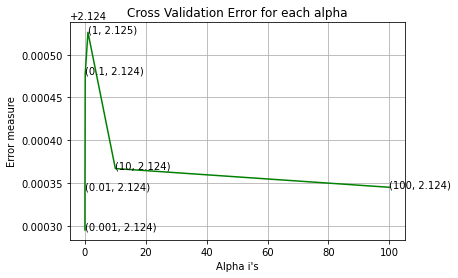

log loss for train data 2.1233597318336446
log loss for cv data 2.1242951977955418
log loss for test data 2.124354991689253


In [41]:
import matplotlib.pyplot as plt
best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(lr_train_1,project_data_y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(lr_train_1, project_data_y_train)
pred_y=sig_clf.predict(lr_test_1)

predict_y = sig_clf.predict_proba(lr_train_1)
print ('log loss for train data',log_loss(project_data_y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(lr_cv_1)
print ('log loss for cv data',log_loss(project_data_y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(lr_test_1)
print ('log loss for test data',log_loss(project_data_y_test, predict_y, labels=logisticR.classes_, eps=1e-15))

In [42]:
alpha=[5,10,50]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(lr_train_1,project_data_y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(lr_train_1, project_data_y_train)
    predict_y = sig_clf.predict_proba(lr_cv_1)
    cv_log_error_array.append(log_loss(project_data_y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    print(f"Done alpha== {i}")
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:29:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:29:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:29:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done alpha== 5


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:30:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:31:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done alpha== 10


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:31:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:32:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:32:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:33:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:33:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:34:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done alpha== 50
log_loss for c =  5 is 2.124142414759515
log_loss for c =  10 is 2.1241374011920438
log_loss for c =  50 is 2.124172789021281


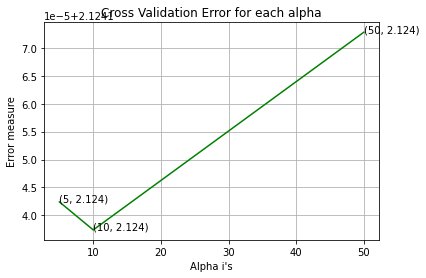

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:34:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:35:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:35:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:35:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:35:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:35:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log loss for train data 2.1230697772081415
log loss for cv data 2.124163824514942
log loss for test data 2.124207932113278


In [43]:
import matplotlib.pyplot as plt
best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
x_cfl.fit(lr_train_1,project_data_y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(lr_train_1, project_data_y_train)
pred_y=sig_clf.predict(lr_test_1)

predict_y = sig_clf.predict_proba(lr_train_1)
print ('log loss for train data',log_loss(project_data_y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(lr_cv_1)
print ('log loss for cv data',log_loss(project_data_y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(lr_test_1)
print ('log loss for test data',log_loss(project_data_y_test, predict_y, labels=logisticR.classes_, eps=1e-15))

**Note:**
1. I Have used   different vectorizer other than count vectorizer. Ex:- (Tfidf, w2v etc)
2. Training time of w2v will be much greater than count and tfidf vectorizer.
3. We can also try RandomForect, knn, NeuralNetwork.
4. Loss is logloss for multiclass classification.
5. We can also tweak number of alpha's, to check robustness of above model.
6. Divided train, cv and test and then vectorize it to avoid data leakage(Increase model robustness)